In [543]:
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import cv2
import fnmatch
import os
import glob

In [544]:
df = pd.read_csv('data.txt', sep=" ", header=None)
df_normal_marked = pd.read_csv('saved.csv')
df.columns = ["ID", "background_tissue", "class",
              "severity", "x", "y", "rad"]
df = df.dropna()
df.index = df.index + 1

In [545]:
df_normal_marked['severity'] = 'N'

In [546]:
df_final = pd.concat([df, df_normal_marked], axis=0)

In [722]:
df_final

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,...,mean_erode,var_erode,std_erode,min_pixel_erode,max_pixel_erode,min_coor_x_erode,min_coor_y_erode,max_coor_x_erode,max_coor_y_erode,bdips_erode
0,mdb001,G,CIRC,0,535,425,197.0,150.781051,3205.504934,56.617179,...,145.328215,3258.043762,57.079276,5.0,217.0,371,708,584,598,0.000008
1,mdb002,G,CIRC,0,522,280,69.0,197.870827,764.537398,27.650269,...,193.119138,904.499352,30.074896,58.0,226.0,569,794,528,676,0.000063
2,mdb005,F,CIRC,0,477,133,30.0,149.605105,409.222292,20.229243,...,142.003899,500.080453,22.362479,76.0,174.0,464,918,475,876,0.000010
3,mdb005,F,CIRC,0,500,168,26.0,162.426214,80.178549,8.954248,...,156.487977,94.573288,9.724880,126.0,173.0,493,831,521,861,0.000620
4,mdb010,F,CIRC,0,525,425,33.0,184.385157,127.091607,11.273491,...,178.766207,134.473062,11.596252,154.0,200.0,558,599,520,599,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,mdb318,D,NORM,2,442,68,50.0,14.033015,0.505857,0.711236,...,13.095857,0.230200,0.479791,11.0,14.0,434,949,442,906,0.002019
303,mdb319,D,NORM,2,590,281,50.0,145.912938,28.130725,5.303841,...,141.277884,21.720868,4.660565,130.0,159.0,585,776,639,743,0.000043
304,mdb320,D,NORM,2,495,264,50.0,195.578840,470.810515,21.698168,...,190.905163,514.108278,22.673956,145.0,224.0,486,809,524,720,0.000036
305,mdb321,D,NORM,2,604,271,50.0,177.764946,30.464061,5.519426,...,173.387763,24.682272,4.968126,163.0,191.0,624,738,555,747,0.000087


In [548]:
df_final = df_final.reset_index(drop=True)
del df_final["Unnamed: 0"]

In [549]:
df_final

,ID,background_tissue,class,severity,x,y,rad
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb005,F,CIRC,B,477,133,30.0
3,mdb005,F,CIRC,B,500,168,26.0
4,mdb010,F,CIRC,B,525,425,33.0
...,...,...,...,...,...,...,...
307,mdb318,D,NORM,N,442,68,50.0
308,mdb319,D,NORM,N,590,281,50.0
309,mdb320,D,NORM,N,495,264,50.0
310,mdb321,D,NORM,N,604,271,50.0


In [254]:
def img_erode():
    for index, row in df_final.iterrows():
        path = 'all-mias/{name}.pgm'.format(name=row['ID'])
        im = cv2.imread('all-mias/{name}.pgm'.format(name=row['ID']), 0)
        #img = cv2.imread('j.png',0)
        kernel = np.ones((5,5),np.uint8)
        erosion = cv2.erode(im,kernel,iterations=1) 
        cv2.imwrite('erode/{}.png'.format(row['ID']), erosion)
img_erode()

In [231]:
def img_canny():
    for index, row in df_final.iterrows():
        path = 'all-mias/{name}.pgm'.format(name=row['ID'])
        im = cv2.imread('all-mias/{name}.pgm'.format(name=row['ID']))
        img_cvt=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        fin = cv2.Canny(img_cvt,10,20)
        cv2.imwrite('canny/{}.png'.format(row['ID']), fin)
img_canny()

In [121]:
df_normal = pd.read_csv('data.txt', sep=" ", header=None)
df_normal.columns = ["ID", "background_tissue", "class",
              "severity", "x", "y", "rad"]

In [122]:
df_normal = df_normal.loc[df_normal['class']  == 'NORM']
df_normal = df_normal.reset_index(drop=True)

In [123]:
df_normal

,ID,background_tissue,class,severity,x,y,rad
0,mdb003,D,NORM,NaN,NaN,NaN,NaN
1,mdb004,D,NORM,NaN,NaN,NaN,NaN
2,mdb006,F,NORM,NaN,NaN,NaN,NaN
3,mdb007,G,NORM,NaN,NaN,NaN,NaN
4,mdb008,G,NORM,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
202,mdb318,D,NORM,NaN,NaN,NaN,NaN
203,mdb319,D,NORM,NaN,NaN,NaN,NaN
204,mdb320,D,NORM,NaN,NaN,NaN,NaN
205,mdb321,D,NORM,NaN,NaN,NaN,NaN


In [124]:
df['severity'].value_counts()

B    69
M    54
Name: severity, dtype: int64

In [10]:
im = Image.open('all-mias/mdb001.pgm') # PILLOW image processing

In [11]:
im.getpixel( (535,425) )

155

In [110]:
last = 'start'

In [111]:
def img_draw(image, x, y, r, c):
    if c=='M':
        color = 'red'
    else:
        color = 'blue'
    draw = ImageDraw.Draw(image)
    leftUpPoint = (x-r, y-r)
    rightDownPoint = (x+r, y+r)
    twoPointList = [leftUpPoint, rightDownPoint]
    draw.ellipse(twoPointList, outline=color, width=5)

In [ ]:
for index, row in df.iterrows():
    path = 'all-mias/{name}.pgm'.format(name=row['ID'])
    if last != path:
        im = Image.open(path).convert("RGB")
    x = int(row['x'])
    y = int(row['y'])
    r = int(row['rad'])
    c = row['severity']
    img_draw(im, x, 1024 - y, r, c)
    im.save("marked/{}.png".format(row['ID']))
    last = path

In [147]:
df_final

,ID,background_tissue,class,severity,x,y,rad
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477,133,30.0
...,...,...,...,...,...,...,...
518,mdb318,D,NORM,NaN,442,68,50.0
519,mdb319,D,NORM,NaN,590,281,50.0
520,mdb320,D,NORM,NaN,495,264,50.0
521,mdb321,D,NORM,NaN,604,271,50.0


In [232]:
## CANNNY
mean = []
var = []
std = []
max_v = []
min_v = []
min_coor_x = []
min_coor_y = []
max_coor_x = []
max_coor_y = []
for index, row in df_final.iterrows():
    path = 'canny/{name}.png'.format(name=row['ID'])
    im = cv2.imread('canny/{name}.png'.format(name=row['ID']))
    h,w,d = im.shape
    x = int(row['x'])
    y = int(row['y'])
    r = int(row['rad'])
    #c = row['severity']
    mask = np.zeros((h,w), np.uint8)
    cv2.circle(mask,(x,1024-y),r ,1,thickness=-1)
    masked_data = cv2.bitwise_and(im, im, mask=mask)
    
    mean.append(cv2.meanStdDev(im, mask = mask)[0][0])
    var.append(np.power(cv2.meanStdDev(im, mask = mask)[1][0], 2))
    std.append(cv2.meanStdDev(im, mask = mask)[1][0])
    
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gray, mask = mask)
    
    max_v.append(max_val)
    min_v.append(min_val)
    min_coor_x.append(min_loc[0])
    min_coor_y.append(min_loc[1])
    max_coor_x.append(max_loc[0])
    max_coor_y.append(max_loc[1])


In [255]:
## Erode
mean = []
var = []
std = []
max_v = []
min_v = []
min_coor_x = []
min_coor_y = []
max_coor_x = []
max_coor_y = []
for index, row in df_final.iterrows():
    path = 'erode/{name}.png'.format(name=row['ID'])
    im = cv2.imread('erode/{name}.png'.format(name=row['ID']))
    h,w,d = im.shape
    x = int(row['x'])
    y = int(row['y'])
    r = int(row['rad'])
    #c = row['severity']
    mask = np.zeros((h,w), np.uint8)
    cv2.circle(mask,(x,1024-y),r ,1,thickness=-1)
    masked_data = cv2.bitwise_and(im, im, mask=mask)
    
    mean.append(cv2.meanStdDev(im, mask = mask)[0][0])
    var.append(np.power(cv2.meanStdDev(im, mask = mask)[1][0], 2))
    std.append(cv2.meanStdDev(im, mask = mask)[1][0])
    
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gray, mask = mask)
    
    max_v.append(max_val)
    min_v.append(min_val)
    min_coor_x.append(min_loc[0])
    min_coor_y.append(min_loc[1])
    max_coor_x.append(max_loc[0])
    max_coor_y.append(max_loc[1])


In [256]:
df_final['mean_erode'] = np.array(mean)
df_final['var_erode'] = np.array(var)
df_final['std_erode'] = np.array(std)
df_final['min_pixel_erode'] = np.array(min_v)
df_final['max_pixel_erode'] = np.array(max_v)
df_final['min_coor_x_erode'] = np.array(min_coor_x)
df_final['min_coor_y_erode'] = np.array(min_coor_y)
df_final['max_coor_x_erode'] = np.array(max_coor_x)
df_final['max_coor_y_erode'] = np.array(max_coor_y)

In [233]:
df_final['mean_canny'] = np.array(mean)
df_final['var_canny'] = np.array(var)
df_final['std_canny'] = np.array(std)
df_final['min_pixel_canny'] = np.array(min_v)
df_final['max_pixel_canny'] = np.array(max_v)
df_final['min_coor_x_canny'] = np.array(min_coor_x)
df_final['min_coor_y_canny'] = np.array(min_coor_y)
df_final['max_coor_x_canny'] = np.array(max_coor_x)
df_final['max_coor_y_canny'] = np.array(max_coor_y)

In [216]:
mean = []
var = []
std = []
max_v = []
min_v = []
min_coor_x = []
min_coor_y = []
max_coor_x = []
max_coor_y = []
for index, row in df_final.iterrows():
    path = 'all-mias/{name}.pgm'.format(name=row['ID'])
    im = cv2.imread('all-mias/{name}.pgm'.format(name=row['ID']))
    h,w,d = im.shape
    x = int(row['x'])
    y = int(row['y'])
    r = int(row['rad'])
    #c = row['severity']
    mask = np.zeros((h,w), np.uint8)
    cv2.circle(mask,(x,1024-y),r ,1,thickness=-1)
    masked_data = cv2.bitwise_and(im, im, mask=mask)
    
    mean.append(cv2.meanStdDev(im, mask = mask)[0][0])
    var.append(np.power(cv2.meanStdDev(im, mask = mask)[1][0], 2))
    std.append(cv2.meanStdDev(im, mask = mask)[1][0])
    
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gray, mask = mask)
    
    max_v.append(max_val)
    min_v.append(min_val)
    min_coor_x.append(min_loc[0])
    min_coor_y.append(min_loc[1])
    max_coor_x.append(max_loc[0])
    max_coor_y.append(max_loc[1])


In [217]:
df_final['mean'] = np.array(mean)
df_final['var'] = np.array(var)
df_final['std'] = np.array(std)
df_final['min_pixel'] = np.array(min_v)
df_final['max_pixel'] = np.array(max_v)
df_final['min_coor_x'] = np.array(min_coor_x)
df_final['min_coor_y'] = np.array(min_coor_y)
df_final['max_coor_x'] = np.array(max_coor_x)
df_final['max_coor_y'] = np.array(max_coor_y)

In [257]:
df_final

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,...,std_canny,mean_erode,var_erode,std_erode,min_pixel_erode,max_pixel_erode,min_coor_x_erode,min_coor_y_erode,max_coor_x_erode,max_coor_y_erode
0,mdb001,G,CIRC,B,535,425,197.0,150.781051,3205.504934,56.617179,...,112.945588,145.328215,3258.043762,57.079276,5.0,217.0,371,708,584,598
1,mdb002,G,CIRC,B,522,280,69.0,197.870827,764.537398,27.650269,...,103.247451,193.119138,904.499352,30.074896,58.0,226.0,569,794,528,676
2,mdb005,F,CIRC,B,477,133,30.0,149.605105,409.222292,20.229243,...,117.540999,142.003899,500.080453,22.362479,76.0,174.0,464,918,475,876
3,mdb005,F,CIRC,B,500,168,26.0,162.426214,80.178549,8.954248,...,116.307381,156.487977,94.573288,9.724880,126.0,173.0,493,831,521,861
4,mdb010,F,CIRC,B,525,425,33.0,184.385157,127.091607,11.273491,...,119.127056,178.766207,134.473062,11.596252,154.0,200.0,558,599,520,599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,mdb318,D,NORM,N,442,68,50.0,14.033015,0.505857,0.711236,...,12.200599,13.095857,0.230200,0.479791,11.0,14.0,434,949,442,906
308,mdb319,D,NORM,N,590,281,50.0,145.912938,28.130725,5.303841,...,118.449283,141.277884,21.720868,4.660565,130.0,159.0,585,776,639,743
309,mdb320,D,NORM,N,495,264,50.0,195.578840,470.810515,21.698168,...,108.471641,190.905163,514.108278,22.673956,145.0,224.0,486,809,524,720
310,mdb321,D,NORM,N,604,271,50.0,177.764946,30.464061,5.519426,...,118.201415,173.387763,24.682272,4.968126,163.0,191.0,624,738,555,747


In [258]:
df_final.to_csv("finErode.csv")

In [259]:
all_coor = []
def get_all_coor():
    for index, row in df_final.iterrows():
        coordinates = []
        for x in range( int(row['x']) - int(row['rad']) ,  int(row['x']) + int(row['rad']) ) :
            for y in range( int(row['y']) - int(row['rad']), int(row['y']) + int(row['rad']) ):
                dx = x - int(row['x'])
                dy = y - int(row['y'])
                distanceSquared = dx * dx + dy * dy
                if (distanceSquared <= row['rad']**2):
                    coordinates.append((x,y))
        all_coor.append(coordinates)

In [260]:
get_all_coor()

In [261]:
bdips = []
#original is all-mias
def bdip():    
    for index, row in df_final.iterrows():
        path = 'erode/{name}.png'.format(name=row['ID'])
        im = cv2.imread('erode/{name}.png'.format(name=row['ID']))
        s = 0
        for x, y in all_coor[index]:
            s += im[row['max_coor_y'],row['max_coor_x']] - im[y, x]
        bdips.append( (s[0]/(row['rad']**2*3.14*im[row['max_coor_y'],row['max_coor_x']]))[0] )    

In [80]:
im = cv2.imread('all-mias/mdb001.pgm')

In [262]:
bdip()
bdips

<ipython-input-261-1b548d193135>:10: RuntimeWarning: divide by zero encountered in true_divide
  bdips.append( (s[0]/(row['rad']**2*3.14*im[row['max_coor_y'],row['max_coor_x']]))[0] )


[7.625498936395408e-06,
 6.33241334961923e-05,
 1.0286541911486364e-05,
 0.0006198834817417039,
 7.347835079428774e-06,
 2.575871112776321e-05,
 7.647594754973613e-05,
 3.73206478234761e-06,
 8.977526429837809e-05,
 3.299530435904793e-05,
 3.9992298549760605e-06,
 0.00020886054354180163,
 3.983378076649275e-05,
 1.048907945702727e-05,
 8.287007876037281e-05,
 4.874063936021087e-05,
 0.00019614146935280626,
 0.0002003039973707296,
 9.99108351302482e-05,
 0.00027080896052688593,
 0.0006746834281557642,
 0.001056656444129905,
 1.7397988402825692e-06,
 0.00015842181554134163,
 4.441652301470737e-05,
 0.00033023306311522874,
 3.2899731642694825e-05,
 2.7178114819417913e-05,
 6.2678582943939e-05,
 6.802544777580934e-05,
 2.8069747709107593e-05,
 7.533072023517883e-05,
 5.388545643137015e-06,
 2.3560427998460527e-05,
 0.00012307302668685216,
 2.4836178579197326e-06,
 1.0386054808723436e-06,
 2.56053344087921e-05,
 7.325930559656532e-06,
 8.797656426730095e-06,
 0.00021182418403032185,
 1.3646

In [263]:
df_final['bdips_erode'] = np.array(bdips)

In [489]:
df_final.to_csv("final_with_erode.csv")

In [490]:
df_final.reset_index(drop=True,inplace=True)

In [979]:
df_final

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,...,mean_erode,var_erode,std_erode,min_pixel_erode,max_pixel_erode,min_coor_x_erode,min_coor_y_erode,max_coor_x_erode,max_coor_y_erode,bdips_erode
0,mdb001,G,CIRC,B,535,425,197.0,150.781051,3205.504934,56.617179,...,145.328215,3258.043762,57.079276,5.0,217.0,371,708,584,598,0.000008
1,mdb002,G,CIRC,B,522,280,69.0,197.870827,764.537398,27.650269,...,193.119138,904.499352,30.074896,58.0,226.0,569,794,528,676,0.000063
2,mdb005,F,CIRC,B,477,133,30.0,149.605105,409.222292,20.229243,...,142.003899,500.080453,22.362479,76.0,174.0,464,918,475,876,0.000010
3,mdb005,F,CIRC,B,500,168,26.0,162.426214,80.178549,8.954248,...,156.487977,94.573288,9.724880,126.0,173.0,493,831,521,861,0.000620
4,mdb010,F,CIRC,B,525,425,33.0,184.385157,127.091607,11.273491,...,178.766207,134.473062,11.596252,154.0,200.0,558,599,520,599,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,mdb318,D,NORM,N,442,68,50.0,14.033015,0.505857,0.711236,...,13.095857,0.230200,0.479791,11.0,14.0,434,949,442,906,0.002019
308,mdb319,D,NORM,N,590,281,50.0,145.912938,28.130725,5.303841,...,141.277884,21.720868,4.660565,130.0,159.0,585,776,639,743,0.000043
309,mdb320,D,NORM,N,495,264,50.0,195.578840,470.810515,21.698168,...,190.905163,514.108278,22.673956,145.0,224.0,486,809,524,720,0.000036
310,mdb321,D,NORM,N,604,271,50.0,177.764946,30.464061,5.519426,...,173.387763,24.682272,4.968126,163.0,191.0,624,738,555,747,0.000087


In [106]:
df_final.to_csv("final.csv")

In [185]:
df_final.to_csv("final2.csv")

In [1173]:
df_final = pd.read_csv('final_with_erode_1.csv')
df_final.reset_index(drop=True,inplace=True)
del df_final['Unnamed: 0']

In [1174]:
df_final['severity'].isnull().any()

False

In [1175]:
df_final['severity'].replace('N',2,inplace=True)
df_final['severity'].replace('M',1,inplace=True)
df_final['severity'].replace('B',0,inplace=True)

In [1176]:
df_final

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,...,mean_erode,var_erode,std_erode,min_pixel_erode,max_pixel_erode,min_coor_x_erode,min_coor_y_erode,max_coor_x_erode,max_coor_y_erode,bdips_erode
0,mdb001,G,CIRC,0,535,425,197.0,150.781051,3205.504934,56.617179,...,145.328215,3258.043762,57.079276,5.0,217.0,371,708,584,598,0.000008
1,mdb002,G,CIRC,0,522,280,69.0,197.870827,764.537398,27.650269,...,193.119138,904.499352,30.074896,58.0,226.0,569,794,528,676,0.000063
2,mdb005,F,CIRC,0,477,133,30.0,149.605105,409.222292,20.229243,...,142.003899,500.080453,22.362479,76.0,174.0,464,918,475,876,0.000010
3,mdb005,F,CIRC,0,500,168,26.0,162.426214,80.178549,8.954248,...,156.487977,94.573288,9.724880,126.0,173.0,493,831,521,861,0.000620
4,mdb010,F,CIRC,0,525,425,33.0,184.385157,127.091607,11.273491,...,178.766207,134.473062,11.596252,154.0,200.0,558,599,520,599,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,mdb318,D,NORM,2,442,68,50.0,14.033015,0.505857,0.711236,...,13.095857,0.230200,0.479791,11.0,14.0,434,949,442,906,0.002019
308,mdb319,D,NORM,2,590,281,50.0,145.912938,28.130725,5.303841,...,141.277884,21.720868,4.660565,130.0,159.0,585,776,639,743,0.000043
309,mdb320,D,NORM,2,495,264,50.0,195.578840,470.810515,21.698168,...,190.905163,514.108278,22.673956,145.0,224.0,486,809,524,720,0.000036
310,mdb321,D,NORM,2,604,271,50.0,177.764946,30.464061,5.519426,...,173.387763,24.682272,4.968126,163.0,191.0,624,738,555,747,0.000087


In [747]:
df_final = df_final.drop(['ID'], axis=1)

In [994]:
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.dropna(inplace=True)
df_final.reset_index(inplace=True)

In [996]:
del df_final['index']

In [1000]:
df_final.to_csv('pleaseFinal/final.csv')

In [1008]:
df_final

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,...,mean_erode,var_erode,std_erode,min_pixel_erode,max_pixel_erode,min_coor_x_erode,min_coor_y_erode,max_coor_x_erode,max_coor_y_erode,bdips_erode
0,mdb001,G,CIRC,0,535,425,197.0,150.781051,3205.504934,56.617179,...,145.328215,3258.043762,57.079276,5.0,217.0,371,708,584,598,0.000008
1,mdb002,G,CIRC,0,522,280,69.0,197.870827,764.537398,27.650269,...,193.119138,904.499352,30.074896,58.0,226.0,569,794,528,676,0.000063
2,mdb005,F,CIRC,0,477,133,30.0,149.605105,409.222292,20.229243,...,142.003899,500.080453,22.362479,76.0,174.0,464,918,475,876,0.000010
3,mdb005,F,CIRC,0,500,168,26.0,162.426214,80.178549,8.954248,...,156.487977,94.573288,9.724880,126.0,173.0,493,831,521,861,0.000620
4,mdb010,F,CIRC,0,525,425,33.0,184.385157,127.091607,11.273491,...,178.766207,134.473062,11.596252,154.0,200.0,558,599,520,599,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,mdb318,D,NORM,2,442,68,50.0,14.033015,0.505857,0.711236,...,13.095857,0.230200,0.479791,11.0,14.0,434,949,442,906,0.002019
303,mdb319,D,NORM,2,590,281,50.0,145.912938,28.130725,5.303841,...,141.277884,21.720868,4.660565,130.0,159.0,585,776,639,743,0.000043
304,mdb320,D,NORM,2,495,264,50.0,195.578840,470.810515,21.698168,...,190.905163,514.108278,22.673956,145.0,224.0,486,809,524,720,0.000036
305,mdb321,D,NORM,2,604,271,50.0,177.764946,30.464061,5.519426,...,173.387763,24.682272,4.968126,163.0,191.0,624,738,555,747,0.000087


In [636]:
df_final.to_csv('finally.csv')

In [978]:
df_finally.to_csv('testtesttest.csv')

In [833]:
df_finally

,background_tissue,class,severity,x,y,rad,mean,var,std,min_pixel,...,80,81,82,83,84,85,86,87,88,89
0,G,CIRC,0,535,425,197.0,150.781051,3205.504934,56.617179,5.0,...,0.077495,0.057131,0.000132,0.047860,0.047598,0.047088,0.047985,0.026360,0.048619,0.055781
1,G,CIRC,0,522,280,69.0,197.870827,764.537398,27.650269,75.0,...,0.086103,0.076059,0.075255,0.083965,0.086875,0.086078,0.074783,0.070293,0.085699,0.085855
2,F,CIRC,0,477,133,30.0,149.605105,409.222292,20.229243,84.0,...,0.035906,0.038000,0.039495,0.037046,0.035816,0.037235,0.054409,0.064430,0.037220,0.053017
3,F,CIRC,0,500,168,26.0,162.426214,80.178549,8.954248,128.0,...,0.061391,0.052185,0.068811,0.053869,0.055789,0.062539,0.069416,0.051520,0.068235,0.068537
4,F,CIRC,0,525,425,33.0,184.385157,127.091607,11.273491,155.0,...,0.064772,0.064836,0.065186,0.063458,0.065509,0.065687,0.066656,0.068120,0.064197,0.064024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,D,NORM,2,442,68,50.0,14.033015,0.505857,0.711236,11.0,...,0.005631,0.005673,0.005622,0.005519,0.005574,0.005585,0.005657,0.005522,0.005617,0.005573
303,D,NORM,2,590,281,50.0,145.912938,28.130725,5.303841,130.0,...,0.057100,0.056467,0.057069,0.055745,0.056172,0.057144,0.057615,0.062998,0.055317,0.056784
304,D,NORM,2,495,264,50.0,195.578840,470.810515,21.698168,146.0,...,0.086635,0.090627,0.078840,0.089521,0.072025,0.071708,0.072373,0.084510,0.090469,0.090238
305,D,NORM,2,604,271,50.0,177.764946,30.464061,5.519426,163.0,...,0.071060,0.066745,0.070574,0.076844,0.071334,0.068290,0.067408,0.066900,0.066901,0.070000


In [1076]:
df_finally

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,...,80,81,82,83,84,85,86,87,88,89
0,mdb001,G,CIRC,0,535,425,197.0,150.781051,3205.504934,56.617179,...,0.077495,0.057131,0.000132,0.047860,0.047598,0.047088,0.047985,0.026360,0.048619,0.055781
1,mdb002,G,CIRC,0,522,280,69.0,197.870827,764.537398,27.650269,...,0.086103,0.076059,0.075255,0.083965,0.086875,0.086078,0.074783,0.070293,0.085699,0.085855
2,mdb005,F,CIRC,0,477,133,30.0,149.605105,409.222292,20.229243,...,0.035906,0.038000,0.039495,0.037046,0.035816,0.037235,0.054409,0.064430,0.037220,0.053017
3,mdb005,F,CIRC,0,500,168,26.0,162.426214,80.178549,8.954248,...,0.061391,0.052185,0.068811,0.053869,0.055789,0.062539,0.069416,0.051520,0.068235,0.068537
4,mdb010,F,CIRC,0,525,425,33.0,184.385157,127.091607,11.273491,...,0.064772,0.064836,0.065186,0.063458,0.065509,0.065687,0.066656,0.068120,0.064197,0.064024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,mdb318,D,NORM,2,442,68,50.0,14.033015,0.505857,0.711236,...,0.005631,0.005673,0.005622,0.005519,0.005574,0.005585,0.005657,0.005522,0.005617,0.005573
303,mdb319,D,NORM,2,590,281,50.0,145.912938,28.130725,5.303841,...,0.057100,0.056467,0.057069,0.055745,0.056172,0.057144,0.057615,0.062998,0.055317,0.056784
304,mdb320,D,NORM,2,495,264,50.0,195.578840,470.810515,21.698168,...,0.086635,0.090627,0.078840,0.089521,0.072025,0.071708,0.072373,0.084510,0.090469,0.090238
305,mdb321,D,NORM,2,604,271,50.0,177.764946,30.464061,5.519426,...,0.071060,0.066745,0.070574,0.076844,0.071334,0.068290,0.067408,0.066900,0.066901,0.070000


In [1011]:
df_final.drop(['min_coor_x','min_coor_y','max_coor_x', 'max_coor_y'], axis=1,inplace=True)

In [1014]:
df_final.drop(['min_coor_x_erode','min_coor_y_erode','max_coor_x_erode','max_coor_y_erode'], axis=1,inplace=True)

In [1016]:
df_final.to_csv('pleaseFinal/final_no_wavelets.csv')

In [1138]:
df_finally.severity

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,...,80,81,82,83,84,85,86,87,88,89
0,mdb001,G,CIRC,0,535,425,197.0,150.781051,3205.504934,56.617179,...,0.077495,0.057131,0.000132,0.047860,0.047598,0.047088,0.047985,0.026360,0.048619,0.055781
1,mdb002,G,CIRC,0,522,280,69.0,197.870827,764.537398,27.650269,...,0.086103,0.076059,0.075255,0.083965,0.086875,0.086078,0.074783,0.070293,0.085699,0.085855
2,mdb005,F,CIRC,0,477,133,30.0,149.605105,409.222292,20.229243,...,0.035906,0.038000,0.039495,0.037046,0.035816,0.037235,0.054409,0.064430,0.037220,0.053017
3,mdb005,F,CIRC,0,500,168,26.0,162.426214,80.178549,8.954248,...,0.061391,0.052185,0.068811,0.053869,0.055789,0.062539,0.069416,0.051520,0.068235,0.068537
4,mdb010,F,CIRC,0,525,425,33.0,184.385157,127.091607,11.273491,...,0.064772,0.064836,0.065186,0.063458,0.065509,0.065687,0.066656,0.068120,0.064197,0.064024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,mdb318,D,NORM,2,442,68,50.0,14.033015,0.505857,0.711236,...,0.005631,0.005673,0.005622,0.005519,0.005574,0.005585,0.005657,0.005522,0.005617,0.005573
303,mdb319,D,NORM,2,590,281,50.0,145.912938,28.130725,5.303841,...,0.057100,0.056467,0.057069,0.055745,0.056172,0.057144,0.057615,0.062998,0.055317,0.056784
304,mdb320,D,NORM,2,495,264,50.0,195.578840,470.810515,21.698168,...,0.086635,0.090627,0.078840,0.089521,0.072025,0.071708,0.072373,0.084510,0.090469,0.090238
305,mdb321,D,NORM,2,604,271,50.0,177.764946,30.464061,5.519426,...,0.071060,0.066745,0.070574,0.076844,0.071334,0.068290,0.067408,0.066900,0.066901,0.070000


In [1181]:
#x = df_final.loc[:,'x':'bdips_erode']
#x = df_wavelets_norm.loc[:,'0':'89']
x = df_finally.loc[:, 'mean':]

In [1182]:
df_finally

,ID,background_tissue,class,severity,x,y,rad,mean,var,std,...,80,81,82,83,84,85,86,87,88,89
0,mdb001,G,CIRC,0,535,425,197.0,150.781051,3205.504934,56.617179,...,0.077495,0.057131,0.000132,0.047860,0.047598,0.047088,0.047985,0.026360,0.048619,0.055781
1,mdb002,G,CIRC,0,522,280,69.0,197.870827,764.537398,27.650269,...,0.086103,0.076059,0.075255,0.083965,0.086875,0.086078,0.074783,0.070293,0.085699,0.085855
2,mdb005,F,CIRC,0,477,133,30.0,149.605105,409.222292,20.229243,...,0.035906,0.038000,0.039495,0.037046,0.035816,0.037235,0.054409,0.064430,0.037220,0.053017
3,mdb005,F,CIRC,0,500,168,26.0,162.426214,80.178549,8.954248,...,0.061391,0.052185,0.068811,0.053869,0.055789,0.062539,0.069416,0.051520,0.068235,0.068537
4,mdb010,F,CIRC,0,525,425,33.0,184.385157,127.091607,11.273491,...,0.064772,0.064836,0.065186,0.063458,0.065509,0.065687,0.066656,0.068120,0.064197,0.064024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,mdb318,D,NORM,2,442,68,50.0,14.033015,0.505857,0.711236,...,0.005631,0.005673,0.005622,0.005519,0.005574,0.005585,0.005657,0.005522,0.005617,0.005573
303,mdb319,D,NORM,2,590,281,50.0,145.912938,28.130725,5.303841,...,0.057100,0.056467,0.057069,0.055745,0.056172,0.057144,0.057615,0.062998,0.055317,0.056784
304,mdb320,D,NORM,2,495,264,50.0,195.578840,470.810515,21.698168,...,0.086635,0.090627,0.078840,0.089521,0.072025,0.071708,0.072373,0.084510,0.090469,0.090238
305,mdb321,D,NORM,2,604,271,50.0,177.764946,30.464061,5.519426,...,0.071060,0.066745,0.070574,0.076844,0.071334,0.068290,0.067408,0.066900,0.066901,0.070000


In [1183]:
len(x.columns)

105

In [1184]:
y = df_finally.loc[:, 'severity']

In [1002]:
df_wavelets = pd.read_csv('wavelets_finally.csv', index_col=0)

In [1003]:
df_wavelets

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,43.406035,10414.277406,16.651703,9047.216133,3190.304378,9677.197969,14.245546,10421.997235,23.870225,-18.022087,...,12501.020583,9244.848467,21.200939,7829.556789,7610.982145,7595.030384,7660.351531,4320.638788,7867.102297,9048.221284
1,13929.236027,13916.320329,13786.313165,13931.999031,13014.352016,12128.335802,13908.124073,11596.837242,14109.619582,11307.657489,...,13889.681763,12307.654154,12107.796557,13736.214998,13891.452862,13883.737653,11938.400184,11521.623117,13867.017795,13926.611845
2,10521.260453,8765.546375,8764.339895,8808.398823,8871.362848,4987.170924,8951.247096,8763.015567,8783.330793,10519.702073,...,5792.168354,6149.101026,6354.321784,6060.479661,5727.075496,6005.710302,8685.943346,10560.632976,6022.533599,8599.918289
3,8362.871735,8039.810825,8335.541432,8034.460719,8378.615520,9019.387880,9864.312576,9866.446846,8971.665160,8490.961685,...,9903.336820,8444.444603,11070.993009,8812.659431,8920.768819,10087.070972,11081.719832,8444.643023,11041.184786,11117.506216
4,10691.289688,10416.965199,10645.853632,10459.532249,10455.805227,10288.004831,11123.826744,10389.065879,10406.076160,10372.594016,...,10448.729376,10491.579510,10487.795530,10381.342412,10475.115226,10594.787153,10641.117706,11165.465537,10387.713075,10385.434859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,913.009856,911.370996,914.784922,906.177090,910.985187,905.896696,907.905502,907.334802,906.242716,903.633530,...,908.337463,918.005721,904.543764,902.929538,891.336223,900.812973,903.120105,905.049594,908.888760,904.024490
303,9225.769845,9138.947015,9222.298950,9270.328639,9111.191662,9111.649870,9155.209965,9225.437542,9201.368911,9231.438314,...,9211.077087,9137.342763,9181.931348,9119.624451,8982.031251,9216.967763,9197.763708,10326.021694,8950.950589,9211.041321
304,9613.855025,10577.249827,9657.831274,10529.464964,9610.176137,10739.491604,9335.249903,9631.647493,9334.454263,9845.451712,...,13975.550153,14665.010301,12684.573202,14645.145704,11516.951938,11566.027093,11553.706354,13851.962460,14638.858948,14637.645859
305,10611.346312,11207.648809,12635.683382,10618.214770,10621.124665,10624.755457,12454.628841,10786.558799,10756.445681,10602.389319,...,11463.110501,10800.529394,11354.754272,12571.290625,11406.453425,11014.738105,10761.127192,10965.531622,10825.268033,11354.754801


In [1004]:
from sklearn.preprocessing import normalize
df_wavelets_norm = normalize(df_wavelets, norm='l2', axis=0, copy=True, return_norm=False)

In [1139]:
df_finally['severity'].value_counts()

2    188
0     68
1     51
Name: severity, dtype: int64

In [1005]:
df_wavelets_norm = pd.DataFrame(df_wavelets_norm)

In [1006]:
df_wavelets_norm

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,0.000263,0.062338,0.000101,0.054960,0.019558,0.058787,0.000087,0.063402,0.000145,-0.000109,...,0.077495,0.057131,0.000132,0.047860,0.047598,0.047088,0.047985,0.026360,0.048619,0.055781
1,0.084489,0.083301,0.083484,0.084634,0.079785,0.073678,0.084932,0.070549,0.085811,0.068543,...,0.086103,0.076059,0.075255,0.083965,0.086875,0.086078,0.074783,0.070293,0.085699,0.085855
2,0.063817,0.052469,0.053073,0.053509,0.054386,0.030296,0.054662,0.053310,0.053418,0.063766,...,0.035906,0.038000,0.039495,0.037046,0.035816,0.037235,0.054409,0.064430,0.037220,0.053017
3,0.050725,0.048125,0.050476,0.048808,0.051365,0.054791,0.060238,0.060023,0.054563,0.051469,...,0.061391,0.052185,0.068811,0.053869,0.055789,0.062539,0.069416,0.051520,0.068235,0.068537
4,0.064849,0.062354,0.064467,0.063539,0.064100,0.062498,0.067930,0.063202,0.063287,0.062875,...,0.064772,0.064836,0.065186,0.063458,0.065509,0.065687,0.066656,0.068120,0.064197,0.064024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.005538,0.005455,0.005540,0.005505,0.005585,0.005503,0.005544,0.005520,0.005512,0.005477,...,0.005631,0.005673,0.005622,0.005519,0.005574,0.005585,0.005657,0.005522,0.005617,0.005573
303,0.055959,0.054704,0.055846,0.056315,0.055857,0.055352,0.055908,0.056123,0.055960,0.055957,...,0.057100,0.056467,0.057069,0.055745,0.056172,0.057144,0.057615,0.062998,0.055317,0.056784
304,0.058313,0.063313,0.058484,0.063964,0.058916,0.065241,0.057007,0.058594,0.056770,0.059679,...,0.086635,0.090627,0.078840,0.089521,0.072025,0.071708,0.072373,0.084510,0.090469,0.090238
305,0.064364,0.067087,0.076516,0.064503,0.065113,0.064544,0.076056,0.065620,0.065418,0.064268,...,0.071060,0.066745,0.070574,0.076844,0.071334,0.068290,0.067408,0.066900,0.066901,0.070000


In [1007]:
df_wavelets

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,43.406035,10414.277406,16.651703,9047.216133,3190.304378,9677.197969,14.245546,10421.997235,23.870225,-18.022087,...,12501.020583,9244.848467,21.200939,7829.556789,7610.982145,7595.030384,7660.351531,4320.638788,7867.102297,9048.221284
1,13929.236027,13916.320329,13786.313165,13931.999031,13014.352016,12128.335802,13908.124073,11596.837242,14109.619582,11307.657489,...,13889.681763,12307.654154,12107.796557,13736.214998,13891.452862,13883.737653,11938.400184,11521.623117,13867.017795,13926.611845
2,10521.260453,8765.546375,8764.339895,8808.398823,8871.362848,4987.170924,8951.247096,8763.015567,8783.330793,10519.702073,...,5792.168354,6149.101026,6354.321784,6060.479661,5727.075496,6005.710302,8685.943346,10560.632976,6022.533599,8599.918289
3,8362.871735,8039.810825,8335.541432,8034.460719,8378.615520,9019.387880,9864.312576,9866.446846,8971.665160,8490.961685,...,9903.336820,8444.444603,11070.993009,8812.659431,8920.768819,10087.070972,11081.719832,8444.643023,11041.184786,11117.506216
4,10691.289688,10416.965199,10645.853632,10459.532249,10455.805227,10288.004831,11123.826744,10389.065879,10406.076160,10372.594016,...,10448.729376,10491.579510,10487.795530,10381.342412,10475.115226,10594.787153,10641.117706,11165.465537,10387.713075,10385.434859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,913.009856,911.370996,914.784922,906.177090,910.985187,905.896696,907.905502,907.334802,906.242716,903.633530,...,908.337463,918.005721,904.543764,902.929538,891.336223,900.812973,903.120105,905.049594,908.888760,904.024490
303,9225.769845,9138.947015,9222.298950,9270.328639,9111.191662,9111.649870,9155.209965,9225.437542,9201.368911,9231.438314,...,9211.077087,9137.342763,9181.931348,9119.624451,8982.031251,9216.967763,9197.763708,10326.021694,8950.950589,9211.041321
304,9613.855025,10577.249827,9657.831274,10529.464964,9610.176137,10739.491604,9335.249903,9631.647493,9334.454263,9845.451712,...,13975.550153,14665.010301,12684.573202,14645.145704,11516.951938,11566.027093,11553.706354,13851.962460,14638.858948,14637.645859
305,10611.346312,11207.648809,12635.683382,10618.214770,10621.124665,10624.755457,12454.628841,10786.558799,10756.445681,10602.389319,...,11463.110501,10800.529394,11354.754272,12571.290625,11406.453425,11014.738105,10761.127192,10965.531622,10825.268033,11354.754801


In [782]:
df_final

,background_tissue,class,severity,x,y,rad,mean,var,std,min_pixel,...,mean_erode,var_erode,std_erode,min_pixel_erode,max_pixel_erode,min_coor_x_erode,min_coor_y_erode,max_coor_x_erode,max_coor_y_erode,bdips_erode
0,G,CIRC,0,535,425,197.0,150.781051,3205.504934,56.617179,5.0,...,145.328215,3258.043762,57.079276,5.0,217.0,371,708,584,598,0.000008
1,G,CIRC,0,522,280,69.0,197.870827,764.537398,27.650269,75.0,...,193.119138,904.499352,30.074896,58.0,226.0,569,794,528,676,0.000063
2,F,CIRC,0,477,133,30.0,149.605105,409.222292,20.229243,84.0,...,142.003899,500.080453,22.362479,76.0,174.0,464,918,475,876,0.000010
3,F,CIRC,0,500,168,26.0,162.426214,80.178549,8.954248,128.0,...,156.487977,94.573288,9.724880,126.0,173.0,493,831,521,861,0.000620
4,F,CIRC,0,525,425,33.0,184.385157,127.091607,11.273491,155.0,...,178.766207,134.473062,11.596252,154.0,200.0,558,599,520,599,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,D,NORM,2,442,68,50.0,14.033015,0.505857,0.711236,11.0,...,13.095857,0.230200,0.479791,11.0,14.0,434,949,442,906,0.002019
303,D,NORM,2,590,281,50.0,145.912938,28.130725,5.303841,130.0,...,141.277884,21.720868,4.660565,130.0,159.0,585,776,639,743,0.000043
304,D,NORM,2,495,264,50.0,195.578840,470.810515,21.698168,146.0,...,190.905163,514.108278,22.673956,145.0,224.0,486,809,524,720,0.000036
305,D,NORM,2,604,271,50.0,177.764946,30.464061,5.519426,163.0,...,173.387763,24.682272,4.968126,163.0,191.0,624,738,555,747,0.000087


In [1055]:
df_finally = pd.merge(df_final, df_wavelets_norm,left_index=True, right_index=True)

In [1056]:
df_finally.to_csv("pleaseFinal/final_with_wavelets.csv")

In [883]:
df_finally.drop(['x', 'y', 'rad', 'min_pixel', 
                 'max_pixel', 'min_coor_x', 'min_coor_y',
                'max_coor_x', 'max_coor_y',
                'min_pixel_erode','max_pixel_erode', 'min_coor_x_erode',
                 'min_coor_y_erode','max_coor_x_erode','max_coor_y_erode'],axis=1,inplace=True)

In [884]:
df_finally.to_csv("finalfinal.csv")

In [885]:
df_finally

,background_tissue,class,severity,mean,var,std,bdips,mean_canny,var_canny,std_canny,...,80,81,82,83,84,85,86,87,88,89
0,G,CIRC,0,150.781051,3205.504934,56.617179,0.000007,68.343054,12756.705742,112.945588,...,0.077495,0.057131,0.000132,0.047860,0.047598,0.047088,0.047985,0.026360,0.048619,0.055781
1,G,CIRC,0,197.870827,764.537398,27.650269,0.000055,52.692153,10660.036075,103.247451,...,0.086103,0.076059,0.075255,0.083965,0.086875,0.086078,0.074783,0.070293,0.085699,0.085855
2,F,CIRC,0,149.605105,409.222292,20.229243,0.000087,78.099965,13815.886498,117.540999,...,0.035906,0.038000,0.039495,0.037046,0.035816,0.037235,0.054409,0.064430,0.037220,0.053017
3,F,CIRC,0,162.426214,80.178549,8.954248,0.000578,75.261669,13527.406777,116.307381,...,0.061391,0.052185,0.068811,0.053869,0.055789,0.062539,0.069416,0.051520,0.068235,0.068537
4,F,CIRC,0,184.385157,127.091607,11.273491,0.000287,82.057788,14191.255387,119.127056,...,0.064772,0.064836,0.065186,0.063458,0.065509,0.065687,0.066656,0.068120,0.064197,0.064024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,D,NORM,2,14.033015,0.505857,0.711236,0.000641,0.585086,148.854615,12.200599,...,0.005631,0.005673,0.005622,0.005519,0.005574,0.005585,0.005657,0.005522,0.005617,0.005573
303,D,NORM,2,145.912938,28.130725,5.303841,0.000114,80.319312,14030.232648,118.449283,...,0.057100,0.056467,0.057069,0.055745,0.056172,0.057144,0.057615,0.062998,0.055317,0.056784
304,D,NORM,2,195.578840,470.810515,21.698168,0.000004,60.491396,11766.096962,108.471641,...,0.086635,0.090627,0.078840,0.089521,0.072025,0.071708,0.072373,0.084510,0.090469,0.090238
305,D,NORM,2,177.764946,30.464061,5.519426,0.000026,79.701721,13971.574509,118.201415,...,0.071060,0.066745,0.070574,0.076844,0.071334,0.068290,0.067408,0.066900,0.066901,0.070000


In [837]:
y.isnull().any()

False

In [838]:
df_final['severity'].replace('N',2,inplace=True)
df_final['severity'].replace('M',1,inplace=True)
df_final['severity'].replace('B',0,inplace=True)

In [1197]:
from sklearn.preprocessing import StandardScaler as ss
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [1149]:
scale = ss()
x = scale.fit_transform(x)

In [1150]:
pca = PCA()
out = pca.fit_transform(x)
out.shape

(307, 105)

In [1151]:
pca.explained_variance_ratio_

array([6.58486233e-01, 4.68263531e-02, 2.81686029e-02, 1.94816586e-02,
       1.57587896e-02, 1.13467073e-02, 1.04010544e-02, 9.69994377e-03,
       8.13667628e-03, 7.78398597e-03, 7.49958210e-03, 7.40472371e-03,
       6.95277083e-03, 6.61228941e-03, 6.32120749e-03, 6.23631627e-03,
       5.77744426e-03, 5.59685244e-03, 5.14329263e-03, 5.06703442e-03,
       5.03316649e-03, 4.80964582e-03, 4.53414723e-03, 4.32697413e-03,
       4.25193041e-03, 3.98993929e-03, 3.86117255e-03, 3.84257422e-03,
       3.67793130e-03, 3.40197399e-03, 3.26253151e-03, 3.24005892e-03,
       2.99224980e-03, 2.94488522e-03, 2.80362292e-03, 2.69531448e-03,
       2.62754514e-03, 2.58761781e-03, 2.42877610e-03, 2.37995644e-03,
       2.22949656e-03, 2.19088120e-03, 2.14914627e-03, 1.97157094e-03,
       1.90045788e-03, 1.85583040e-03, 1.74514705e-03, 1.66844078e-03,
       1.63736536e-03, 1.59137030e-03, 1.48830322e-03, 1.47142418e-03,
       1.38740169e-03, 1.29619531e-03, 1.23819386e-03, 1.21942468e-03,
      

In [1152]:
pca.explained_variance_ratio_.cumsum()

array([0.65848623, 0.70531259, 0.73348119, 0.75296285, 0.76872164,
       0.78006834, 0.7904694 , 0.80016934, 0.80830602, 0.81609001,
       0.82358959, 0.83099431, 0.83794708, 0.84455937, 0.85088058,
       0.8571169 , 0.86289434, 0.86849119, 0.87363448, 0.87870152,
       0.88373469, 0.88854433, 0.89307848, 0.89740545, 0.90165738,
       0.90564732, 0.90950849, 0.91335107, 0.917029  , 0.92043097,
       0.92369351, 0.92693356, 0.92992581, 0.9328707 , 0.93567432,
       0.93836964, 0.94099718, 0.9435848 , 0.94601358, 0.94839353,
       0.95062303, 0.95281391, 0.95496306, 0.95693463, 0.95883509,
       0.96069092, 0.96243606, 0.9641045 , 0.96574187, 0.96733324,
       0.96882154, 0.97029297, 0.97168037, 0.97297656, 0.97421476,
       0.97543418, 0.97661533, 0.97776833, 0.97888429, 0.97997579,
       0.9810395 , 0.98204519, 0.98303243, 0.983993  , 0.98492015,
       0.98579782, 0.98666379, 0.98752057, 0.98832619, 0.98906295,
       0.98976619, 0.99044571, 0.99110238, 0.99171298, 0.99229

In [1153]:
a = np.asarray(pca.explained_variance_ratio_.cumsum())
za = (a < .95).sum()
za

40

In [1154]:
final_data = out[:,:40]

In [1155]:
final_data.shape

(307, 40)

In [1156]:
col = []
for i in range(0, 40):
    col.append(str(i))

In [1157]:
pcdf = pd.DataFrame( data =  final_data,columns=col)
                    #columns = ['pc1', 'pc2','pc3', 'pc4','pc5','pc6'])

In [1090]:
df_finally['severity'].reset_index(drop=True)

0      0
1      0
2      0
3      0
4      0
      ..
302    2
303    2
304    2
305    2
306    2
Name: severity, Length: 307, dtype: int64

In [1091]:
df_finally['severity'].isnull().any()

False

In [1158]:
pcdf['target'] = df_final['severity'].reset_index(drop=True)

In [1159]:
pcdf

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,target
0,10.399375,5.954563,1.669743,-0.766329,1.141715,-0.394535,0.051233,-0.805472,1.066595,-0.877166,...,-0.170121,-0.944491,-0.002118,0.058001,-0.897841,-0.068617,0.637450,0.303901,-1.414984,0
1,-7.802078,1.370569,-2.213215,1.765407,-1.243189,-1.351639,-1.512502,-1.556030,0.913861,-1.738008,...,1.063609,-2.276330,0.024931,-1.280635,-1.486564,1.251751,-0.863455,-0.054287,-1.699811,0
2,0.773770,0.493942,-0.833675,-0.390183,0.572615,-0.240075,0.269914,-0.236026,0.849565,-0.002897,...,0.682240,-0.302727,0.170416,-0.087768,0.526271,0.186137,1.021874,0.585008,0.620989,0
3,-2.688816,-0.743430,1.456193,-0.476470,0.183885,-0.480131,0.033712,0.088625,-0.002761,0.052778,...,-0.102487,0.225342,0.247462,0.254703,-0.136077,-0.183779,0.119898,0.706875,0.479122,0
4,-5.851168,-0.510248,0.431953,-0.155228,0.144483,0.058656,-0.006451,0.014919,-0.065559,-0.064201,...,0.045570,-0.051902,0.029378,0.116171,0.173626,0.195392,-0.060906,0.088484,-0.027742,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,20.579780,-3.421998,1.448503,0.410913,-2.407824,-0.257112,-0.324246,0.190173,0.005176,-0.148349,...,-0.055885,-0.114243,-0.040795,-0.012178,-0.061074,-0.097035,-0.131328,-0.050895,0.057600,2
303,-2.229451,-1.252605,0.412264,-0.556696,0.381516,0.048920,0.085051,-0.113920,-0.277450,-0.041702,...,0.101101,-0.280529,0.128719,0.152801,0.007986,-0.077564,-0.042133,-0.025312,0.247216,2
304,-8.903930,0.861015,2.817987,0.670153,-1.120012,-0.123168,0.378190,0.800240,0.278871,-0.163801,...,0.040150,0.146272,-0.592055,0.644798,-0.932641,-0.677823,-0.055555,-0.292700,0.193417,2
305,-7.750343,-0.988173,0.768029,0.042701,-0.194520,-0.078252,0.321771,0.351409,-0.029831,0.570522,...,0.269947,-0.174675,-0.156236,0.177746,0.268532,-0.067056,-0.060760,-0.022916,-0.029328,2


In [1160]:
#X = pcdf.loc[: , 'pc1':'pc6']
X = pcdf.loc[: , '0':'39']
y = pcdf.loc[:,'target']

In [1185]:
X_train, X_test, y_train, y_test = train_test_split(x ,y, test_size = 0.2,shuffle=True)

In [1097]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

In [1098]:
y.isnull().any()

False

In [1099]:
y.to_csv('y.csv')

In [1186]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.datasets import make_hastie_10_2
from sklearn.svm import SVC

In [1192]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(units=32, activation='relu', input_shape=(105,)))
Dropout(0.25)
model.add(Dense(units=32, activation='relu'))
Dropout(0.25)
model.add(Dense(units=3, activation='softmax'))
model.summary()



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                3392      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 99        
Total params: 4,547
Trainable params: 4,547
Non-trainable params: 0
_________________________________________________________________


In [1193]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify = y_train)

ValueError: Found input variables with inconsistent numbers of samples: [245, 183]

In [1194]:
y_train = keras.utils.to_categorical(y_train, 3)
y_val = keras.utils.to_categorical(y_val, 3)
y_test = keras.utils.to_categorical(y_test, 3)

In [1190]:
from tensorflow.keras.optimizers import SGD
# Compile model
epochs = 100
lr = 0.001
# decay = lr/epochs
# sgd = SGD(lr=lr, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=lr), metrics=['accuracy'])

In [1191]:
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(x_val, y_val))

Epoch 1/100


ValueError: in user code:

    C:\Users\linhvt22\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\linhvt22\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\linhvt22\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\linhvt22\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\linhvt22\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\linhvt22\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\linhvt22\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\linhvt22\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\linhvt22\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_6 is incompatible with the layer: expected axis -1 of input shape to have value 40 but received input with shape (None, 105)


In [1195]:
svm = SVC(probability=True)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100)
xg = XGBClassifier(learning_rate=0.5,
                   reg_alpha= 5,
                   reg_lambda= 0.1
                   )
gbm = GradientBoostingClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()

In [1196]:
svm1 = svm.fit(X_train,y_train)
dt1 = dt.fit(X_train,y_train)
rf1 = rf.fit(X_train,y_train)
xg1 = xg.fit(X_train,y_train)
gbm1 = gbm.fit(X_train,y_train)
et1 = et.fit(X_train,y_train)
knn1 = knn.fit(X_train,y_train)

ValueError: y should be a 1d array, got an array of shape (183, 3, 3) instead.

In [1103]:
y_pred_svm = svm1.predict(X_test)
y_pred_dt = dt1.predict(X_test)
y_pred_rf = rf1.predict(X_test)
y_pred_xg= xg1.predict(X_test)
y_pred_gbm= gbm1.predict(X_test)
y_pred_et= et1.predict(X_test)
y_pred_knn= knn1.predict(X_test)

In [1104]:

y_pred_svm_prob = svm1.predict_proba(X_test)
y_pred_dt_prob = dt1.predict_proba(X_test)
y_pred_rf_prob = rf1.predict_proba(X_test)
y_pred_xg_prob = xg1.predict_proba(X_test)
y_pred_gbm_prob= gbm1.predict_proba(X_test)
y_pred_et_prob= et1.predict_proba(X_test)
y_pred_knn_prob= knn1.predict_proba(X_test)



In [1105]:
print("SVM", accuracy_score(y_test,y_pred_svm))
print ("DecisionTreeClassifier",accuracy_score(y_test,y_pred_dt))
print ("RandomForestClassifier",accuracy_score(y_test,y_pred_rf))
print (accuracy_score(y_test,y_pred_xg))
print (accuracy_score(y_test,y_pred_gbm))
print (accuracy_score(y_test,y_pred_et))
print ("KNeighborsClassifier",accuracy_score(y_test,y_pred_knn))

SVM 0.6774193548387096
DecisionTreeClassifier 0.46774193548387094
RandomForestClassifier 0.6612903225806451
0.5967741935483871
0.5806451612903226
0.7096774193548387
KNeighborsClassifier 0.6451612903225806


In [593]:
fpr_dt, tpr_dt, thresholds = roc_curve(y_test,
                                 y_pred_dt_prob[: , 1],
                                 pos_label= 1
                                 )

In [594]:
fpr_rf, tpr_rf, thresholds = roc_curve(y_test,
                                 y_pred_rf_prob[: , 1],
                                 pos_label= 1
                                 )



In [595]:
fpr_xg, tpr_xg, thresholds = roc_curve(y_test,
                                 y_pred_xg_prob[: , 1],
                                 pos_label= 1
                                 )

In [596]:
fpr_gbm, tpr_gbm,thresholds = roc_curve(y_test,
                                 y_pred_gbm_prob[: , 1],
                                 pos_label= 1
                                 )

In [597]:
fpr_et, tpr_et,thresholds = roc_curve(y_test,
                                 y_pred_et_prob[: , 1],
                                 pos_label= 1
                                 )

In [598]:
fpr_knn, tpr_knn,thresholds = roc_curve(y_test,
                                 y_pred_knn_prob[: , 1],
                                 pos_label= 1
                                 )

In [599]:
p_dt,r_dt,f_dt,_ = precision_recall_fscore_support(y_test,y_pred_dt)
p_rf,r_rf,f_rf,_ = precision_recall_fscore_support(y_test,y_pred_rf)
p_gbm,r_gbm,f_gbm,_ = precision_recall_fscore_support(y_test,y_pred_gbm)
p_xg,r_xg,f_xg,_ = precision_recall_fscore_support(y_test,y_pred_xg)
p_et,r_et,f_et,_ = precision_recall_fscore_support(y_test,y_pred_et)
p_knn,r_knn,f_knn,_ = precision_recall_fscore_support(y_test,y_pred_knn)
p_dt,r_dt,f_dt

(array([0.26666667, 0.45454545, 0.83333333]),
 array([0.5       , 0.41666667, 0.71428571]),
 array([0.34782609, 0.43478261, 0.76923077]))

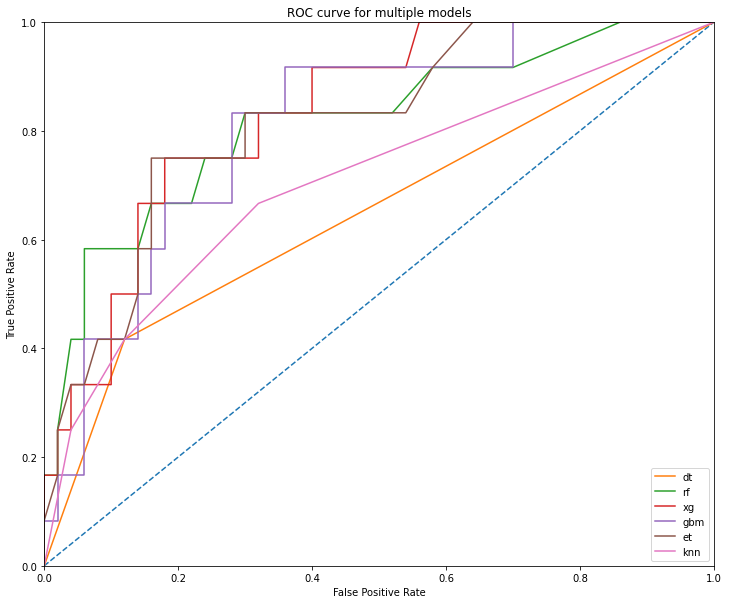

In [600]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,10))          # Create window frame
ax = fig.add_subplot(111)   # Create axes
# 9.2 Also connect diagonals
ax.plot([0, 1], [0, 1], ls="--")   # Dashed diagonal line
# 9.3 Labels etc
ax.set_xlabel('False Positive Rate')  # Final plot decorations
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve for multiple models')
# 9.4 Set graph limits
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

# 9.5 Plot each graph now
ax.plot(fpr_dt, tpr_dt, label = "dt")
ax.plot(fpr_rf, tpr_rf, label = "rf")
ax.plot(fpr_xg, tpr_xg, label = "xg")
ax.plot(fpr_gbm, tpr_gbm, label = "gbm")
ax.plot(fpr_et, tpr_et, label = "et")
ax.plot(fpr_knn, tpr_knn, label = "knn")
# 9.6 Set legend and show plot
ax.legend(loc="lower right")
plt.show()